# Lax-Friedrichs Scheme (1D)

References:
1. Animation in Jupyter notebook: http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
2. Time stamp animation: https://stackoverflow.com/questions/16512308/show-elapsed-timeframe-number-in-matplotlib
3. Wikiepdia Burgers' Equation: https://en.wikipedia.org/wiki/Burgers%27_equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import sparse
%matplotlib inline

A 1D nonlinear problem. $u:[0,T] \times \mathbb{R} \rightarrow \mathbb{R}$,
$$ u_t + (f(u))_x = 0 \quad \text{in } [0,T] \times \mathbb{R}, $$
$$ u(0,x) = v(x) \quad \text{for } x \in \mathbb{R}. $$

For the inviscid 1D Burgers' equation, $f,v \in C^1(\mathbb{R})$,
$$ f(u) = \frac{1}{2} u^2,$$
$$ v(x) = \exp(-x^2).$$

The Lax-Friedrichs scheme for the above problem is
$$ U^{l+1}_j = \frac{1}{2} \left( U_{j+1}^l + U_{j-1}^l \right) - \frac{k}{2h}\left( f(U_{j+1}^l) - f(U_{j-1}^l) \right), \quad l,j \in \mathbb{Z}, l \geq 0, $$
$$ U_j^0 = v(x_j), \quad j \in \mathbb{Z}, $$
where $x_j = jh$, $h, k > 0$ denote the spatial and temporal step sizes respectively.

Finally, the exact solution to the Burger's equation is given implicitly as
$$ u(x,t) = v(x - ut). $$

In [2]:
# define function for the initial condition.
def v(xh):
    return np.exp(-xh**2)
    
# non-linear function of u.
def f(uh):
    return 0.5 * uh**2

# solver for the implicit exact solution
def u_ex(u,x,t):
    return u - np.exp(-(x - u*t)**2)
    
def lfscheme(t,xmin,xmax,h,k):
    # set number of time steps.
    l = np.floor(t/k)
    # set min step for grid.
    jmin = np.ceil(xmin/h)
    # set max step for grid.
    jmax = np.floor(xmax/h)
    
    # define extended grid.
    xh = h * np.arange(jmin-l,jmax+l+1)
    
    # get initial values.
    U = v(xh)

    # recursion for the Lax-Friedrichs scheme.
    while l > 0:
        U = 0.5 * (U[2:] + U[:-2]) - k / (2. * h) * (f(U[2:]) - f(U[:-2]))
        l -= 1

    return U

In [3]:
# space domain
xmin = -3.
xmax = 4.

# time
tmin = 0.
tmax = 3.

p = 8
N = 2.**p
h = 1./N
k = 0.5 * h

# temporal and spatial grids
xh = np.arange(xmin,xmax+h,h)
tk = np.linspace(tmin,tmax,240)

## Plots
Plot the animation of the numerical and exact solutions of the 1D Burgers' equation.

In [4]:
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

fig, ax = plt.subplots()
plt.close()

ax.set_xlim((-3, 4))
ax.set_ylim((-0.5, 1.4))
ax.set_xlabel('x')
ax.set_ylabel('U')

line1, = ax.plot([],[], lw=2)
line2, = ax.plot([],[], lw=2)

time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)

U_ex = np.zeros((xh.shape[0]))

XH = np.repeat(xh.reshape(1,-1),240,axis=0)
TK = np.repeat(tk.reshape(-1,1),xh.shape[0],axis=1)
xx = XH - v(XH) * TK
U_EX = v(xx)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('0.')
    return line1,line2,time_text

def animate(i):
    t = tk[i]
    U = lfscheme(t,xmin,xmax,h,k)
    line1.set_data(xh,U)
    
    # characteristic method
    U_ex = v(xh)
    xx = xh + U_ex * t
    
    line2.set_data(xx, U_ex)
    time_text.set_text('time = %.2f' %t)
    return (line1,time_text)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=240, interval=50, blit=True)

HTML(anim.to_html5_video())

## Errors
Determine the maximum error at a given time $t$ for different grid resolutions.

In [6]:
# pick one point in time to calculate the error.
t = 1.

ps = np.arange(3,11)
errs = np.zeros((ps.shape[0]))

for p in ps:
    N = 2.**p
    h = 1./N
    k = 0.5*h
    
    xh = np.arange(xmin,xmax+h,h)
    U_ex = np.zeros((xh.shape[0]))
    
    j = 0
    for x in xh:
        U_ex[j] = fsolve(u_ex,0,args=(x,t))
        j += 1
        
    U = lfscheme(t,xmin,xmax,h,k)
#    errs[p-3] = np.sqrt(np.sum((U-U_ex)**2) / xh.shape[0]) # L2-error
    errs[p-3] = np.max(np.abs(U-U_ex))
    
from tabulate import tabulate
table = np.hstack((ps.reshape(-1,1),errs.reshape(-1,1)))
table = tabulate(table, headers = ['p', 'max errors'])
print(table)

  p    max errors
---  ------------
  3     0.279779
  4     0.215765
  5     0.160184
  6     0.112458
  7     0.0744375
  8     0.0461618
  9     0.0268384
 10     0.014797


## A first step in data assimilation for the Burgers' Equation.
Reference:
1. Effect of Data Distribution in Data Assimilation Using Burgers' Equation https://dl.acm.org/citation.cfm?doid=331697.332342

4D var with cost functional:
$$ \textbf{Insert cf.} $$

In [7]:
def v(xh):
    return np.sin(xh)

def f(uh):
    return 0.5 * uh**2

def u_ex(u,x,t):
    return u - np.sin(x - u*t)

def lfscheme(t,xmin,xmax,h,k, U0):
    # set number of time steps.
    l = np.floor(t/k)
    # set min step for grid.
    jmin = np.ceil(xmin/h)
    # set max step for grid.
    jmax = np.floor(xmax/h)
    
    # define extended grid.
    xh = h * np.arange(jmin-l,jmax+l+1)
    # get initial values.
    U = np.ones(xh.shape[0])
    
    # dirichlet b.c.
    U[np.where(xh >= xmax)] = 0.
    U[np.where(xh <= xmin)] = 0.
    U[np.where(U != 0.)] = U0

    # period b.c.
#     U[np.where(xh > xmax)[0]] = U0[:len(np.where(xh > xmax)[0])]
#     if len(np.where(xh < xmin)[0]) > 0:
#         U[np.where(xh < xmin)[0]] = U0[-len(np.where(xh < xmin)[0]):]

    # recursion for the Lax-Friedrichs scheme.
    while l > 0:
        U = 0.5 * (U[2:] + U[:-2]) - k / (2. * h) * (f(U[2:]) - f(U[:-2]))
        l -= 1

    return U

In [8]:
# system parameters
sigma2 = 1.
h = 2.*np.pi / 100
k = 1./40
c = k/h
xh = h * np.arange(101)
tk = k * np.arange(41)

# domain sizes
Nx = xh.shape[0]
Nt = tk.shape[0]

# generate exact solutions
U_ex = np.zeros((Nt,Nx))
kk = 0
for t in tk:
    jj = 0
    for x in xh:
        U_ex[kk,jj] = fsolve(u_ex,0,args=(x,t))
        jj += 1
    kk += 1

# observations = reference model + N(0,sigma2)
#obs = np.sqrt(sigma2) * np.random.randn(Nx)
obs = 0.5 * np.sin(2.*xh)
U_obs = np.copy(U_ex)
IDX = [29,39] # choose time to insert observations
U_obs[5,:] += obs

# remove the initial condition and spatial boundaries.
U_obs_tilde = U_obs[1:,1:-1]

# extent of spatial domain.
xmin = xh[0]
xmax = xh[-1]

it = 0
itmax = 600
U0 = v(xh)[1:-1]
delta = 1.
delta_old = 1e1

while ((it < itmax) and (np.abs(delta_old - delta) > 1e-3)):
    # solve U numerically (Lax-Friedrich)
    U = np.zeros((Nt,Nx))
    kk = 0
    for t in tk:
        U[kk,:] = lfscheme(t,xmin,xmax,h,k,U0)
        kk += 1
    
    # save the initial solution (at t = 0).
    if it == 0:
        Uinitial = np.copy(U)
        
    # remove boundaries and initial condition.
    Utilde = U[1:,1:-1]

    # define RHS.
    H = -2. * Utilde + 2. * U_obs_tilde
    H = H.reshape(-1,1, order='c')

    # define matrices to help build A*lambda = H.
    I1 = sparse.eye(Nt-1,Nt-1,k=0,format='csr') # sparse.identity(Nt-1, format='csr') is also possible
    I = sparse.eye(Nx-2,Nx-2,k=0,format='csr')
    I11 = sparse.kron(I1,I,format='csr')
    A2 = sparse.csr_matrix((((Nx-2)*(Nt-1)),((Nx-2)*(Nt-1))))

    # build LHS A. 
    for j in range(0,Nt-2):
        bottom = -0.5 + c * Utilde[j,1:] / 2.
        top = -0.5 - c * Utilde[j,:-1] / 2.

        I2 = sparse.csr_matrix(([1.],([j],[j+1])),shape=(Nt-1,Nt-1))

        Aj = sparse.diags([bottom,top],[-1,1],format='csr')

        A2 += sparse.kron(I2,Aj)

    A = I11 + A2
    
    # get the lambda's at first time step.
    lambda0 = sparse.linalg.spsolve_triangular(A,H,lower=False)[:Nx-2]
    # get the U's at initial time step.
    Ux1 = U[0,1:-1].reshape(-1,1)

    # build gradient.
    right = np.vstack((lambda0[1:],[0.])) / 2.
    left = np.vstack(([0.],lambda0[:-1])) / 2.
    grad = -left + c*left*Ux1 - right - c*right*Ux1

    # convergent criterion
    delta_old = delta
    delta = np.dot(grad.T,grad)[0][0]
    # gradient descent.
    alpha = 0.001
    U0 = U0 - alpha * grad.flatten()
    
    # cost function
    JC = np.sum((U - U_obs)**2)
    print(JC)
    it += 1
    
initerr = np.sqrt(np.mean((U[0,:] - U_ex[0,:])**2))
print('rmse in the initial condition/control vector: %.6f' %initerr)
print('no. of iterations: %i' %it)

/home/ray/anaconda3/envs/playground/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/ray/anaconda3/envs/playground/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


24.957769508069646
24.194272466889608
23.549957867565922
23.00612572850904
22.547022112623463
22.159372989605572
21.831992149568855
21.555451374621235
21.321802950490557
21.12434618058979
20.957430895131573
20.816292066742367
20.696910584534717
20.5958960288694
20.510387952893417
20.437972734507362
20.376613530679883
20.32459125929233
20.280454863995423
20.24297939500277
20.21113067182521
20.184035489791917
20.160956496789023
20.141271004990774
20.124453118671113
20.110058656992262
20.09771243293649
20.08709751875785
20.0779461865707
20.070032261708345
20.063164667748595
20.057181976846
20.051947808269468
20.04734694268854
20.043282040514047
20.03967087009255
20.036443966297732
20.033542652487856
20.03091736927442
20.028526262379565
20.026333989307492
20.02431071083678
20.022431238638593
20.02067431479538
20.019022002765542
20.0174591725218
20.01597306527591
20.014552925469133
20.013189689620845
20.011875723242557
20.010604598388635
20.009370905565948
20.008170094697387
20.006998340655

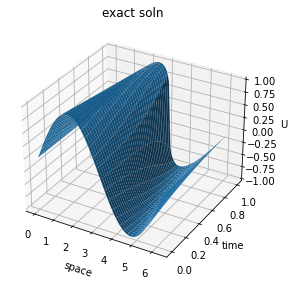

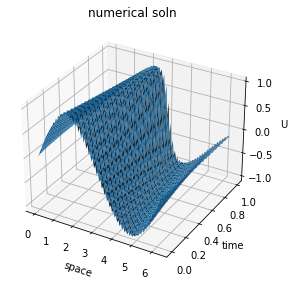

0.05505071635582098


In [22]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

xx, tt = np.meshgrid(xh,tk)

figEX = plt.figure()
ax = figEX.add_subplot(111, projection='3d')
ax.plot_surface(xx,tt,U_ex)
plt.title("exact soln")
ax.set_xlabel("space")
ax.set_ylabel("time")
ax.set_zlabel("U")
plt.tight_layout()
plt.show()

figNUM = plt.figure()

ax = figNUM.add_subplot(111, projection='3d')
ax.plot_surface(xx,tt,U)
plt.title("numerical soln")
ax.set_xlabel("space")
ax.set_ylabel("time")
ax.set_zlabel("U")
plt.tight_layout()
plt.show()

err = np.sqrt(np.mean((Uinitial-U_ex)**2))
print(err)

In [43]:
def Var(itmax, slc, observations):    
    # extent of spatial domain.
    xmin = xh[0]
    xmax = xh[-1]
    
    ll = 0
    initerr = np.zeros((observations.shape[0]))
    plt.figure()
    
    it = 0
    itmax = itmax
    U0 = v(xh)[1:-1]
    delta = 1.
    delta_old = 1e1
    JC_new = 1e1
    JC = 1.
    
    while ((it < itmax) and (np.abs(JC_new - JC) > 1e-6)):
        # solve U numerically (Lax-Friedrich)
        U = np.zeros((Nt,Nx))
        kk = 0
        for t in tk:
            U[kk,:] = lfscheme(t,xmin,xmax,h,k,U0)
            kk += 1

        # save the initial solution (at t = 0).
        if it == 0:
            Uinitial = np.copy(U)

        # remove boundaries and initial condition.
        Utilde = U[1:,1:-1]
        U_obs = np.copy(Utilde)
        U_obs[IDX[ll],slc] += observations[ll]
        
        JC = np.sum((Utilde - U_obs)**2)
        
        # define RHS.
        H = -2. * Utilde + 2. * U_obs
        H = H.reshape(-1,1, order='c')

        # define matrices to help build A*lambda = H.
        I1 = sparse.eye(Nt-1,Nt-1,k=0,format='csr') # sparse.identity(Nt-1, format='csr') is also possible
        I = sparse.eye(Nx-2,Nx-2,k=0,format='csr')
        I11 = sparse.kron(I1,I,format='csr')
        A2 = sparse.csr_matrix((((Nx-2)*(Nt-1)),((Nx-2)*(Nt-1))))

        # build LHS A. 
        for j in range(0,Nt-2):
            bottom = -0.5 + c * Utilde[j,1:] / 2.
            top = -0.5 - c * Utilde[j,:-1] / 2.

            I2 = sparse.csr_matrix(([1.],([j],[j+1])),shape=(Nt-1,Nt-1))

            Aj = sparse.diags([bottom,top],[-1,1],format='csr')

            A2 += sparse.kron(I2,Aj)

        A = I11 + A2

        # get the lambda's at first time step.
        lambda0 = sparse.linalg.spsolve_triangular(A,H,lower=False)[:Nx-2]
        # get the U's at initial time step.
        Ux1 = U0.reshape(-1,1)

        # build gradient.
        right = np.vstack((lambda0[1:],[0.])) / 2.
        left = np.vstack(([0.],lambda0[:-1])) / 2.
        grad = -left + c*left*Ux1 - right - c*right*Ux1

        # convergent criterion
        #delta_old = delta
        #delta = np.dot(grad.T,grad)[0][0]
        # gradient descent.
        alpha = .001
        grad = grad.flatten()
        direction = grad/np.sqrt(np.sum(grad**2))
        U0 = U0 - alpha*direction
#             tol = .0

#             while tol < .5:
#                 Uls0 = U0 - alpha * direction
#                 alpha /= 2.
#                 Uls = np.zeros((Nt,Nx))
#                 kk = 0
#                 for t in tk:
#                     Uls[kk,:] = lfscheme(t,xmin,xmax,h,k,Uls0)
#                     kk += 1
            
#                 Uls_tilde = Uls[1:,1:-1]
#                 JC_new = np.sum((Uls_tilde - U_obs)**2)

#                 if JC_new < JC:
#                     tol = 1.
        
#             U0 = np.copy(Uls0)

        it += 1

    print("it = %i" %it)
    
    plt.plot(xh[1:-1],U0)
    
    initerr[ll] = np.sqrt(np.mean((U[0,:] - Uinitial[0,:])**2))
    ll += 1
        
    plt.plot(xh,Uinitial[0,:])
    plt.show()
    return initerr, U

In [44]:
# system parameters
sigma2 = .01
h = 2.*np.pi / 100
k = 1./40
c = k/h
xh = h * np.arange(101)
tk = k * np.arange(41)

# domain sizes
Nx = xh.shape[0]
Nt = tk.shape[0]

# generate exact solutions
U_ex = np.zeros((Nt,Nx))
kk = 0
for t in tk:
    jj = 0
    for x in xh:
        U_ex[kk,jj] = fsolve(u_ex,0,args=(x,t))
        jj += 1
    kk += 1

/home/ray/anaconda3/envs/playground/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/ray/anaconda3/envs/playground/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


### Error due to distribution of observations over time.

it = 600


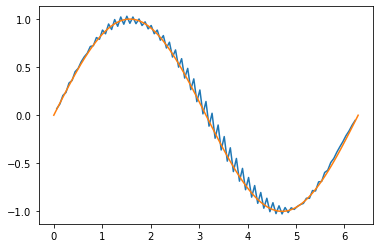

In [46]:
IDX = [1,9,19,29,39] # choose time indices to insert noise to observations
observations = np.zeros((len(IDX),Nt-1,Nx-2))
    
slc = slice(None,)

IDX = [39]

observations = sigma2 * np.random.randn(len(IDX),Nx-2)
initerrs, U = Var(600,slc,observations)

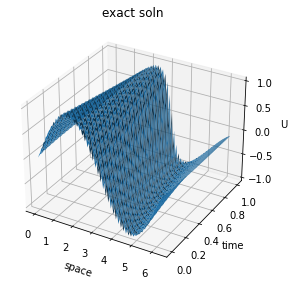

In [47]:
from mpl_toolkits.mplot3d import Axes3D

xx, tt = np.meshgrid(xh,tk)

figEX = plt.figure()
ax = figEX.add_subplot(111, projection='3d')
ax.plot_surface(xx,tt,U)
plt.title("exact soln")
ax.set_xlabel("space")
ax.set_ylabel("time")
ax.set_zlabel("U")
plt.tight_layout()
plt.show()

[0.0594913]


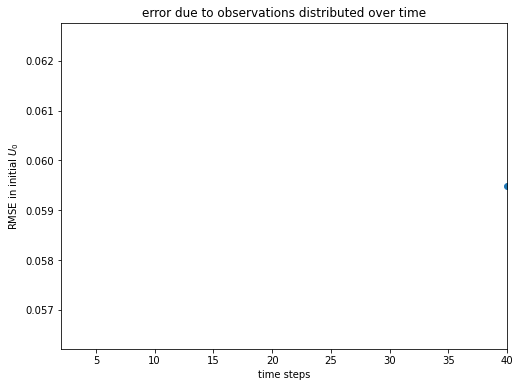

In [48]:
print(initerrs)
fig2 = plt.figure(figsize=(8,6))
plt.plot(np.array(IDX)+1,initerrs, '-o')
plt.xlabel("time steps")
plt.ylabel(r"RMSE in initial $U_0$")
plt.title("error due to observations distributed over time")
plt.xlim([2,40])
plt.show()